In [1]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Flatten, MaxPooling2D, Lambda, ReLU
import pandas as pd
import numpy as np
import cv2, joblib
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Gray Version

In [2]:
df = pd.read_csv("cnn_data_gray.csv")
df.labels = df.labels.astype('category')
lb = joblib.load("labelbinarizer.joblib")
print(df.isnull().values.any())

b_size = 64
channels = 1
dim = 64

x_train, x_test, y_train, y_test = train_test_split(df.img_path, df.labels,
                                                    stratify=df.labels, test_size=0.1, random_state=2020)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

False


In [3]:
x_train_img = np.empty(shape=(0,dim,dim,channels))
for row in x_train:
    frame = cv2.imread(row, 0)/255
    arr = np.reshape(frame, newshape=(1,dim,dim,channels))
    x_train_img = np.append(x_train_img, arr, axis=0)
    
x_test_img = np.empty(shape=(0,dim,dim,channels))
for row in x_test:
    frame = cv2.imread(row, 0)/255
    arr = np.reshape(frame, newshape=(1,dim,dim,channels))
    x_test_img = np.append(x_test_img, arr, axis=0)
    
print("Images Loaded")

Images Loaded


In [4]:
input_layer = Input(shape=(dim,dim,channels))
x = Conv2D(32, (3,3), padding="same")(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output = Dense(15, activation='softmax')(x)
    
# Connect the inputs with the outputs
cnn = Model(inputs=input_layer, outputs=output)

In [5]:
cnn.compile(loss="categorical_crossentropy",optimizer=Adam(lr=0.00006, decay=1e-6), metrics=['acc'])
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64, 64, 32)        0   

In [6]:
history = cnn.fit(x_train_img, y_train, batch_size=b_size, epochs=100, verbose=1,
                          validation_data=(x_test_img,y_test))

Train on 1310 samples, validate on 146 samples
Epoch 1/100
1310/1310 [==============================] - 7s 6ms/step - loss: 1.0241 - acc: 0.7198 - val_loss: 2.7176 - val_acc: 0.0890
Epoch 2/100
1310/1310 [==============================] - 2s 1ms/step - loss: 0.1489 - acc: 0.9565 - val_loss: 2.7567 - val_acc: 0.0411
Epoch 3/100
1310/1310 [==============================] - 2s 1ms/step - loss: 0.0514 - acc: 0.9878 - val_loss: 2.8019 - val_acc: 0.0479
Epoch 4/100
1310/1310 [==============================] - 2s 1ms/step - loss: 0.0186 - acc: 0.9992 - val_loss: 2.8474 - val_acc: 0.0479
Epoch 5/100
1310/1310 [==============================] - 2s 1ms/step - loss: 0.0086 - acc: 0.9985 - val_loss: 2.9349 - val_acc: 0.0479
Epoch 6/100
1310/1310 [==============================] - 2s 1ms/step - loss: 0.0042 - acc: 1.0000 - val_loss: 3.0381 - val_acc: 0.0479
Epoch 7/100
1310/1310 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 3.1622 - val_acc: 0.0959
Epoch 8/

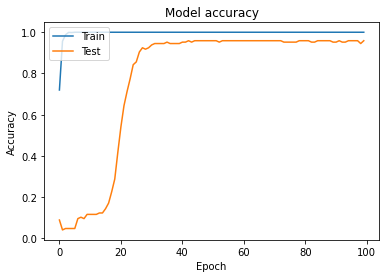

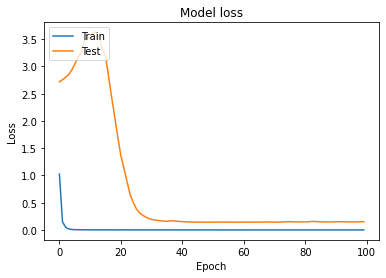

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [9]:
lb.classes_

array(['a', 'b', 'c', 'circle', 'd', 'down', 'e', 'five', 'four', 'left',
       'one', 'right', 'three', 'two', 'up'], dtype='<U6')

In [10]:
preds = cnn.predict(x_test_img)
class_index = preds.argmax(axis=-1)
preds_labels = []
for index in class_index:
    preds_labels.append(lb.classes_[index])

In [11]:
accuracy_score(lb.inverse_transform(y_test), preds_labels)

0.958904109589041

In [13]:
cnn.save_weights('cnn_weights_gray.h5')

## BGR Version

In [2]:
df = pd.read_csv("cnn_data_colour.csv")
df.labels = df.labels.astype('category')
lb = joblib.load("labelbinarizer.joblib")
print(df.isnull().values.any())

b_size = 64
channels = 3
dim = 64

x_train, x_test, y_train, y_test = train_test_split(df.img_path, df.labels,
                                                    stratify=df.labels, test_size=0.1, random_state=2020)
y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

False


In [3]:
x_train_img = np.empty(shape=(0,dim,dim,channels))
for row in x_train:
    frame = cv2.imread(row)/255
    arr = np.reshape(frame, newshape=(1,dim,dim,channels))
    x_train_img = np.append(x_train_img, arr, axis=0)
    
x_test_img = np.empty(shape=(0,dim,dim,channels))
for row in x_test:
    frame = cv2.imread(row)/255
    arr = np.reshape(frame, newshape=(1,dim,dim,channels))
    x_test_img = np.append(x_test_img, arr, axis=0)
    
print("Images Loaded")

Images Loaded


In [4]:
input_layer = Input(shape=(dim,dim,channels))
x = Conv2D(32, (3,3), padding="same")(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(32, (3,3), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Conv2D(64, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Conv2D(128, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Conv2D(256, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, (5,5), padding="same")(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D()(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
output = Dense(15, activation='softmax')(x)
    
# Connect the inputs with the outputs
cnn = Model(inputs=input_layer, outputs=output)

cnn.compile(loss="categorical_crossentropy",optimizer=Adam(lr=0.00006, decay=1e-6), metrics=['acc'])
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 64, 64, 32)        0   

In [13]:
history = cnn.fit(x_train_img, y_train, batch_size=b_size, epochs=50, verbose=1,
                          validation_data=(x_test_img,y_test))

Train on 1033 samples, validate on 115 samples
Epoch 1/50
1033/1033 [==============================] - 1s 1ms/step - loss: 2.7627e-04 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 2/50
1033/1033 [==============================] - 1s 1ms/step - loss: 2.2268e-04 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3/50
1033/1033 [==============================] - 1s 1ms/step - loss: 2.1105e-04 - acc: 1.0000 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 4/50
1033/1033 [==============================] - 1s 1ms/step - loss: 1.9337e-04 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 5/50
1033/1033 [==============================] - 1s 1ms/step - loss: 1.8037e-04 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 6/50
1033/1033 [==============================] - 1s 1ms/step - loss: 1.4100e-04 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 7/50
1033/1033 [==============================] - 1s 1ms/step - loss: 6.3012e-04 - acc: 1.0000 - val_loss: 0.0028 - val

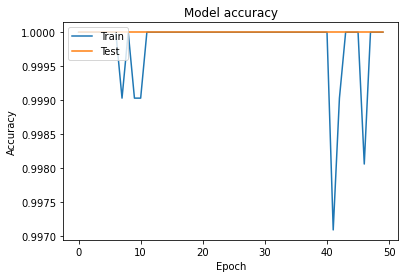

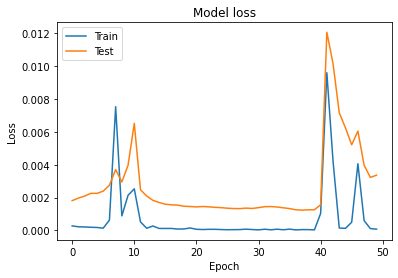

In [14]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
lb.classes_

array(['a', 'b', 'c', 'circle', 'd', 'down', 'e', 'five', 'four', 'left',
       'one', 'right', 'three', 'two', 'up'], dtype='<U6')

In [16]:
preds = cnn.predict(x_test_img)
class_index = preds.argmax(axis=-1)
preds_labels = []
for index in class_index:
    preds_labels.append(lb.classes_[index])

In [17]:
accuracy_score(lb.inverse_transform(y_test), preds_labels)

1.0

In [18]:
cnn.save_weights('cnn_weights_colour.h5')